In [1]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4673279705807094279, name: "/device:XLA_GPU:0"
 device_type: "XLA_GPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 16270833544576290242
 physical_device_desc: "device: XLA_GPU device", name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 13923611723152528772
 physical_device_desc: "device: XLA_CPU device", name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15864515789
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 14463366995608899360
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"]

In [14]:
import numpy as np 
import os
import skimage.io as io
import skimage.transform as trans
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
import keras.backend as K
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.normalization import BatchNormalization
from keras.layers.core import SpatialDropout2D, Activation
from keras import backend as K
from keras.layers.merge import concatenate
from keras.utils.data_utils import get_file

# Number of image channels (for example 3 in case of RGB, or 1 for grayscale images)
INPUT_CHANNELS = 3
# Number of output masks (1 in case you predict only one type of objects)
OUTPUT_MASK_CHANNELS = 1

smooth = 1e-9

# This is the competition metric implemented using Keras
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * (K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return score

# We'll construct a Keras Loss that incorporates the DICE score
def dice_loss(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1. - (2. * intersection + 1.) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.)


def bce_dice_loss(y_true, y_pred):
    return 0.5 * binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)


def double_conv_layer(x, size, dropout=0.0, batch_norm=True):
    if K.image_dim_ordering() == 'th':
        axis = 1
    else:
        axis = 3
    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm is True:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)
    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)
    return conv


def ZF_UNET_224(dropout_val=0.2, weights=None):
    if K.image_dim_ordering() == 'th':
        inputs = Input((INPUT_CHANNELS, 512,512))
        axis = 1
    else:
        inputs = Input((512,512, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1), activation = 'sigmoid')(up_conv_224)
    #conv_final = Activation('sigmoid')(conv_final)
    
    conv_final = Reshape((512,512))(conv_final)

    model = Model(inputs, conv_final, name="ZF_UNET_224")


    return model

In [12]:
from glob import glob
import os

path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')

train_img_paths = glob(glob_train_imgs)
train_mask_paths = glob(glob_train_masks)
print(train_img_paths[:10])
print(train_mask_paths[:10])


path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)
print(val_img_paths[:5])

['train/10729_sat.jpg', 'train/51187_sat.jpg', 'train/52299_sat.jpg', 'train/4962_sat.jpg', 'train/13549_sat.jpg', 'train/15363_sat.jpg', 'train/38456_sat.jpg', 'train/50517_sat.jpg', 'train/32252_sat.jpg', 'train/12993_sat.jpg']
['train/12895_msk.png', 'train/23379_msk.png', 'train/19799_msk.png', 'train/2575_msk.png', 'train/50807_msk.png', 'train/41694_msk.png', 'train/9457_msk.png', 'train/34365_msk.png', 'train/47347_msk.png', 'train/21599_msk.png']
['val/70036_sat.jpg', 'val/75729_sat.jpg', 'val/78249_sat.jpg', 'val/76288_sat.jpg', 'val/71029_sat.jpg']


In [5]:
from skimage.io import imread
from skimage.transform import resize
from skimage.color import rgb2gray

# This will be useful so we can construct the corresponding mask
def get_img_id(img_path):
    img_basename = os.path.basename(img_path)
    img_id = os.path.splitext(img_basename)[0][:-len('_sat')]
    return img_id

# Write it like a normal function
def image_gen(img_paths, img_size=(512, 512)):
    # Iterate over all the image paths
    for img_path in img_paths:
        
        # Construct the corresponding mask path
        img_id = get_img_id(img_path)
        mask_path = os.path.join(path_to_train, img_id + '_msk.png')
        
        # Load the image and mask, and normalize it to 0-1 range
        img = imread(img_path) #/ 255.
        mask = rgb2gray(imread(mask_path))
        
        # Resize the images
        img = resize(img, img_size, preserve_range=True)
        mask = resize(mask, img_size, mode='constant', preserve_range=True)
        # Turn the mask back into a 0-1 mask
        mask = (mask >= 0.5).astype(float)
        
        # Yield the image mask pair
        yield img, mask

In [25]:
model = ZF_UNET_224()
model.summary()
model.compile(Adam(lr=1e-3), loss=bce_dice_loss, metrics=[dice_coef])

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
conv2d_139 (Conv2D)             (None, 512, 512, 32) 896         input_7[0][0]                    
__________________________________________________________________________________________________
batch_normalization_133 (BatchN (None, 512, 512, 32) 128         conv2d_139[0][0]                 
__________________________________________________________________________________________________
activation_136 (Activation)     (None, 512, 512, 32) 0           batch_normalization_133[0][0]    
__________________________________________________________________________________________________
conv2d_140

In [16]:
#compute average image

average = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    average = np.add(average, img)
avg = average/10897

In [18]:
#compute standard deviation image

sd = np.empty((512,512,3))
for i in range(len(train_img_paths)):
    img = imread(train_img_paths[i])
    a = np.subtract(img, avg)
    a = np.square(a)
    sd = np.add(sd, a)
sd = sd/10897
sd = np.sqrt(sd)


In [19]:
print (sd)

[[[ 39.1200441   30.72192687  29.61285695]
  [ 38.77868638  30.33976039  29.19856832]
  [ 39.10822417  30.80489507  29.6288618 ]
  ..., 
  [ 39.18583978  30.78194769  29.5837315 ]
  [ 39.13618024  30.66168139  29.45792469]
  [ 39.32401502  30.83386402  29.66313514]]

 [[ 38.82741266  30.52046149  29.35707065]
  [ 38.56653406  30.27412139  29.15635413]
  [ 38.85624494  30.59314165  29.42201699]
  ..., 
  [ 38.84151894  30.46389985  29.29549341]
  [ 38.7861541   30.31901634  29.15651528]
  [ 38.94979436  30.44723567  29.25764585]]

 [[ 38.88618856  30.65032126  29.37875521]
  [ 38.6366553   30.4113095   29.19209769]
  [ 38.85760468  30.65313014  29.3957739 ]
  ..., 
  [ 38.96857769  30.6371277   29.40583141]
  [ 38.88765944  30.4847065   29.24345273]
  [ 39.09072918  30.68258185  29.4439725 ]]

 ..., 
 [[ 39.10090202  30.75020863  29.16700593]
  [ 38.91490967  30.56485453  29.00246983]
  [ 39.10621445  30.86575636  29.34096964]
  ..., 
  [ 38.65080452  30.30489908  28.88657109]
  [ 38.53

In [24]:
import numpy as np

# Keras takes its input in batches 
# (i.e. a batch size of 32 would correspond to 32 images and 32 masks from the generator)
# The generator should run forever
def image_batch_generator(img_paths, batchsize=32):
    while True:
        ig = image_gen(img_paths)
        batch_img, batch_mask = [], []
        
        for img, mask in ig:
            # Add the image and mask to the batch
            img = np.divide((img - avg),sd) #0 mean, 1 var
            batch_img.append(img)
            batch_mask.append(mask)
            # If we've reached our batchsize, yield the batch and reset
            if len(batch_img) == batchsize:
                yield np.stack(batch_img, axis=0), np.stack(batch_mask, axis=0)
                batch_img, batch_mask = [], []


In [26]:
from sklearn.model_selection import train_test_split
import keras.callbacks
BATCHSIZE = 5

# Split the data into a train and validation set
train_img_paths, val_img_paths = train_test_split(train_img_paths, test_size=0.15)

# Create the train and validation generators
traingen = image_batch_generator(train_img_paths, batchsize=BATCHSIZE)
valgen = image_batch_generator(val_img_paths, batchsize=BATCHSIZE)

def calc_steps(data_len, batchsize):
    return (data_len + batchsize - 1) // batchsize

# Calculate the steps per epoch
train_steps = calc_steps(len(train_img_paths), BATCHSIZE)
val_steps = calc_steps(len(val_img_paths), BATCHSIZE)

filepath="unet.hdf5"

checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=False, save_weights_only=True, mode='auto', period=1)
callbacks_list = [checkpoint]
# Train the model
history = model.fit_generator(
    traingen, 
    steps_per_epoch=train_steps, 
    epochs= 20, # Change this to a larger number to train for longer
    validation_data=valgen, 
    validation_steps=val_steps, 
    verbose=1,
    max_queue_size=5, # Change this number based on memory restrictions
    callbacks = callbacks_list 
)

Epoch 1/20
1339/1339 [==============================] - 544s 407ms/step - loss: 0.8933 - dice_coef: 0.2472 - val_loss: 0.7019 - val_dice_coef: 0.4112
Epoch 2/20
1339/1339 [==============================] - 517s 386ms/step - loss: 0.5977 - dice_coef: 0.4999 - val_loss: 0.5657 - val_dice_coef: 0.5154
Epoch 3/20
1339/1339 [==============================] - 531s 397ms/step - loss: 0.5076 - dice_coef: 0.5759 - val_loss: 0.4995 - val_dice_coef: 0.5766
Epoch 4/20
1339/1339 [==============================] - 531s 397ms/step - loss: 0.4650 - dice_coef: 0.6110 - val_loss: 0.4916 - val_dice_coef: 0.5831
Epoch 5/20
1339/1339 [==============================] - 531s 396ms/step - loss: 0.4345 - dice_coef: 0.6363 - val_loss: 0.4495 - val_dice_coef: 0.6203
Epoch 6/20
1339/1339 [==============================] - 514s 384ms/step - loss: 0.4145 - dice_coef: 0.6530 - val_loss: 0.4399 - val_dice_coef: 0.6284
Epoch 7/20
1339/1339 [==============================] - 532s 398ms/step - loss: 0.3987 - dice_coef: 

KeyboardInterrupt: 

In [12]:
import numpy as np
import pandas as pd

# Create submission DataFrame
def create_submission(csv_name, predictions_gen):
    """
    csv_name -> string for csv ("XXXXXXX.csv")
    predictions -> generator that yields a pair of id, prediction
    """
    sub = pd.DataFrame()
    ids = []
    encodings = []
    num_images = len(val_img_paths)
    for i in range(num_images):
        if (i+1) % (num_images//10) == 0:
            print(i, num_images)
        img_id, pred = next(predictions_gen)
        ids.append(img_id)
        #print (np.count_nonzero(pred == 1))
        encodings.append(rle_encoding(pred))
        
    sub['EncodedPixels'] = encodings
    sub['ImageId'] = ids
    sub.to_csv(csv_name, index=False)

# Run-length encoding stolen from https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
def rle_encoding(x):
    """
    x = numpyarray of size (height, width) representing the mask of an image
    if x[i,j] == 0:
        image[i,j] is not a road pixel
    if x[i,j] != 0:
        image[i,j] is a road pixel
    """
    dots = np.where(x.T.flatten() != 0)[0]
    run_lengths = []
    prev = -2
    for b in dots:
        if (b>prev+1): 
            run_lengths.extend((b+1, 0))
        run_lengths[-1] += 1
        prev = b
    return run_lengths

In [13]:

def generate_pixel_by_pixel_predictions_generator(val_paths):
    for img_path in val_paths:        
        img = imread(img_path)
        img = resize(img, (512, 512), preserve_range=True) 
        img = np.divide((img - avg),sd) #0 mean, 1 var
        y = model.predict(img.reshape(1,512,512,3))  
        y = (y >= 0.5).astype(float) #IMPORTANT- need this or you won't have 0 or 1 (because outputs are probabilities!!)
        yield get_img_id(img_path), y.reshape(512, 512)

In [14]:
import time
import matplotlib.pyplot as plt
path_to_train = 'train'
glob_train_imgs = os.path.join(path_to_train, '*_sat.jpg')
glob_train_masks = os.path.join(path_to_train, '*_msk.png')
train_img_paths = glob(glob_train_imgs)
path_to_val = 'val'
glob_val_imgs = os.path.join(path_to_val, '*_sat.jpg')
val_img_paths = glob(glob_val_imgs)


#first_img, first_mask = next(ig)
"""
img_size = (128,128)
for i in range(30,50): 
    
    img_id = get_img_id(train_img_paths[i])
    mask_path = os.path.join(path_to_train, img_id + '_msk.png')
           
    img = imread(train_img_paths[i]) / 255.
    mask = rgb2gray(imread(mask_path))
    img = resize(img, img_size, preserve_range=True)
    mask = resize(mask, img_size, mode='constant', preserve_range=True)    
    mask = (mask >= 0.5).astype(float)
    
    plt.imshow(mask, cmap='gray')
    plt.show()
    
    y = model.predict(img.reshape(1,128,128,3)) 
    y = (y.reshape(128,128) >= 0.5).astype(float)
    
    plt.imshow(y, cmap='gray')
    plt.show()
    
    
    
    img = imread(val_img_paths[i]) / 255.
    img = resize(img, (128, 128), preserve_range=True)  
    print (get_img_id(val_img_paths[i]))
    y = model.predict(img.reshape(1,128,128,3)) 
    y = (y >= 0.5).astype(float)
    #print (np.count_nonzero(y == 1))
    #print (y)
    plt.imshow(y.reshape(128,128), cmap='gray')
    plt.show()
"""



tic = time.time()
create_submission("unet.csv", generate_pixel_by_pixel_predictions_generator(val_img_paths))
toc = time.time()
print(toc - tic)


215 2169
431 2169
647 2169
863 2169
1079 2169
1295 2169
1511 2169
1727 2169
1943 2169
2159 2169
119.65486407279968


NameError: name 'plot' is not defined

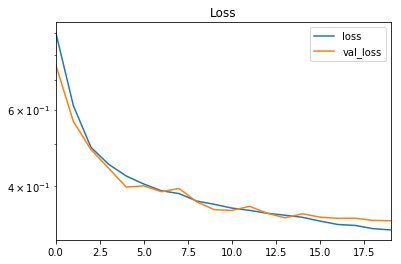

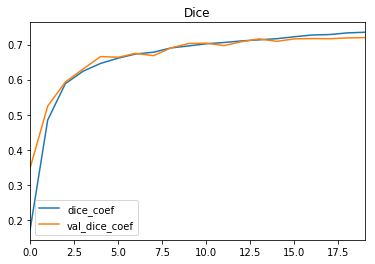

In [20]:
import pandas as pd
%matplotlib inline

# Plot the training curve
pd.DataFrame(history.history)[['loss', 'val_loss']].plot(title="Loss", logy=True)
pd.DataFrame(history.history)[['dice_coef', 'val_dice_coef']].plot(title="Dice")
